# ########### WORK IN PROGRESS!!!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold
from itertools import combinations
from sklearn.feature_selection import SelectKBest, f_classif

# Inital inspection and setting up a basic pipeline

In [2]:
df = pd.read_csv('AmesHousing.tsv', delimiter="\t")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

def train_and_test(df):
    # split 50:50
    train = df[:1460].copy()
    test = df[1460:].copy()
    
    # numeric
    numeric_train = train.select_dtypes(include=['integer','float'])
    numeric_test = test.select_dtypes(include=['integer','float'])
    
    # train
    features = numeric_train.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

# lets create a pipeline function, so  we can just replace names of the input functions to test out the new changes
def pipeline(df=df, t=transform_features, s=select_features, r=train_and_test):
    transform = t(df)
    selected = s(transform)
    rmse = r(selected)
    return rmse

pipeline()

57088.25161263909

In [4]:
def transform_features2(df):
    # handling null values:
   
    # filling using mean for whole column:
    null_count = (df.isnull().sum() / len(df))
    df2 = df[null_count[null_count<0.05].index]
    numeric_df2 = df2.select_dtypes(include=['integer','float'])
    numeric_df2 = numeric_df2.fillna(numeric_df2.mean())
    
    # lets create an age column and filter out rows with negative value:
    numeric_df2['age'] = numeric_df2['Yr Sold'] - numeric_df2['Year Built']
    numeric_df2 = numeric_df2[numeric_df2['age'] >= 0]
    
    # lets create a yrs remod column and filter out rows with negative value: 
    numeric_df2['yrs remod'] = numeric_df2['Yr Sold'] - numeric_df2['Year Remod/Add']
    numeric_df2 = numeric_df2[numeric_df2['yrs remod'] >= 0]
   
    # drop the year cols:
    numeric_df2 = numeric_df2.drop(["Year Built", "Year Remod/Add", 'Yr Sold', 'PID', "Order"], axis = 1)
    return numeric_df2

def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

pipeline(t=transform_features2)

55275.367312413066

In [6]:
# # add on: remove low variance cols
# cols2_drop = numeric_df2.var().sort_values(ascending=False)
# cols2_drop[cols2_drop < 0.3].index.tolist()

# test different feature selection algos

In [24]:
# transform based on corr matrix:
def select_features2(df):
    abs_corr_coeffs = df.corr()['SalePrice'].abs().sort_values(ascending=False)
    cols = abs_corr_coeffs[abs_corr_coeffs > 0.4].index.tolist()
    df = df[cols]

    return df

pipeline(t=transform_features2,s=select_features2)

36636.25030174907

In [27]:
transformed = transform_features2(df)
%timeit select_features2(transformed)

9.35 ms ± 756 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
# transform based on SelectKBest:

def select_features2v2(df):
    numeric_df2 = df.select_dtypes(include=['integer','float'])
    # how many to numeric cols we want to keep?
    numeric_df2 = numeric_df2.drop('SalePrice',axis=1)
    numeric_df2['SalePrice'] = df['SalePrice']
    # how many to numeric cols we want to keep?
    predictors = numeric_df2.columns.tolist()[:-1]
    # Perform feature selection
    selector = SelectKBest(f_classif, k=5)
    selector.fit(numeric_df2[predictors], numeric_df2['SalePrice'])
    # Get the raw p-values for each feature, and transform from p-values into scores
    scores = -np.log10(selector.pvalues_)
    res_frame = pd.DataFrame([predictors,scores]).transpose().sort_values(1,ascending=False)
    res_frame.reset_index(inplace=True)
    res_frame = res_frame.drop('index',axis=1)
    cols = res_frame[0][:14].values.tolist()
    df2 = numeric_df2[cols].copy()
    df2['SalePrice'] = df['SalePrice']
    return df2

pipeline(t=transform_features2,s=select_features2v2)

36669.91992387276

In [45]:
transformed = transform_features2(df)
%timeit select_features2v2(transformed)

92.1 ms ± 9.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Observations:**

The difference in results is very small, we'll choose the first solution. It delivers slightly better results and does that with **only 3 lines of code and 10 times faster.**


# update column cleaning (include dropping text cols)

In [9]:
# transform based on corr matrix:
def transform_features3(df):
    
    # VERSION 3 change: (handling null values in text):   
    null_count = (df.isnull().sum() / len(df))
    df = df[null_count[null_count<0.05].index]
    df = df.fillna(df.select_dtypes(include=['integer','float']).mean())
    
    null_count = df.select_dtypes(include=['object']).isnull().sum()
    textic2_drop = null_count[null_count > 0].index
    df = df.drop(textic2_drop,axis=1) 

    # lets create an age column and filter out rows with negative value:
    df['age'] = df['Yr Sold'] - df['Year Built']
    df = df[df['age'] >= 0]
    
    # lets create a yrs remod column and filter out rows with negative value: 
    df['yrs remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df = df[df['yrs remod'] >= 0]
   
    # drop the year cols:
    df = df.drop(["Year Built", "Year Remod/Add", 'Yr Sold', 'PID', "Order", 'Sale Type', 'Sale Condition',"Mo Sold"], axis = 1)
    return df


pipeline(t=transform_features3,s=select_features2)

36636.25030174907

# update select features

In [10]:
def col_dummy(df, col):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes
    hood_series = pd.get_dummies(df[col],prefix=col)
    df = pd.concat([df, hood_series], axis=1)
    df = df.drop(columns=(col), axis=1)
    return df

In [11]:
categorical_no_leaks = [ "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature"]

categorical_no_leaks2 = []
for col in categorical_no_leaks:
    if (col in df.columns) & (df[col].value_counts().shape[0]>10):
        categorical_no_leaks2.append(col)


def select_features3(df):
    abs_corr_coeffs = df.corr()['SalePrice'].abs().sort_values(ascending=False)
    cols = abs_corr_coeffs[abs_corr_coeffs > 0.4].index.tolist()
    df2 = df[cols].copy()
    for col in categorical_no_leaks2:
        if col in df.columns:
            df2[col] = df[col]
            df2 = col_dummy(df2,col)
            

    return df2

pipeline(t=transform_features3,s=select_features3)

32885.6040324598

# update train and test

In [12]:
def train_and_test2(df, k=5):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

    
# pipeline(t=transform_features3,s=select_features3, r=train_and_test2)
    
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features3(df)
filtered_df = select_features3(transform_df)
rmse = train_and_test2(filtered_df, k=4)

rmse

[28748.081310072695, 27631.93345672669, 25817.333321700833, 35992.37250941498]


29547.4301494788

From the result above, OverallQua
l and GrLivArea are highly correlated with the SalePrice. From this observation we should look up at to these two features and check if there are outliers visible.

# Apply log-transfomation (log(1+x))
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

2.3.2 Remove Outliers




# Remove outliers

In [15]:
abs(df.corr()['SalePrice']).sort_values(ascending=False)[:10]

SalePrice         1.000000
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Name: SalePrice, dtype: float64

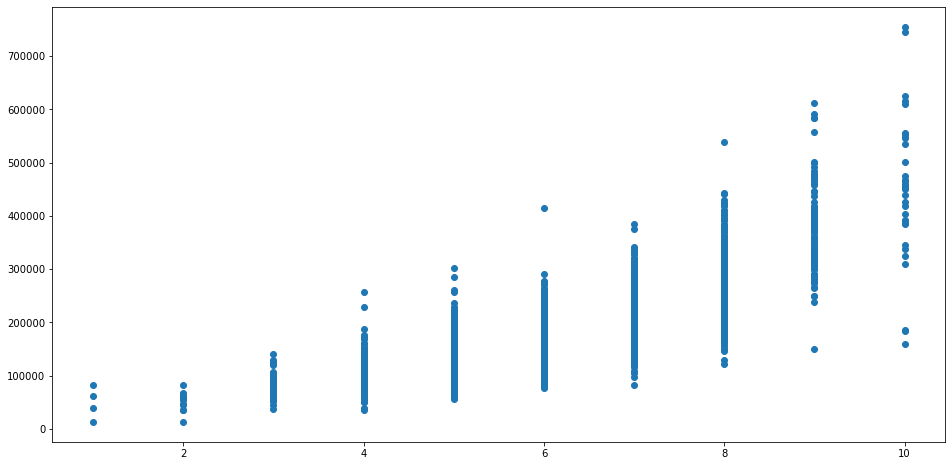

In [16]:
fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(df['Overall Qual'], df["SalePrice"])
plt.show()

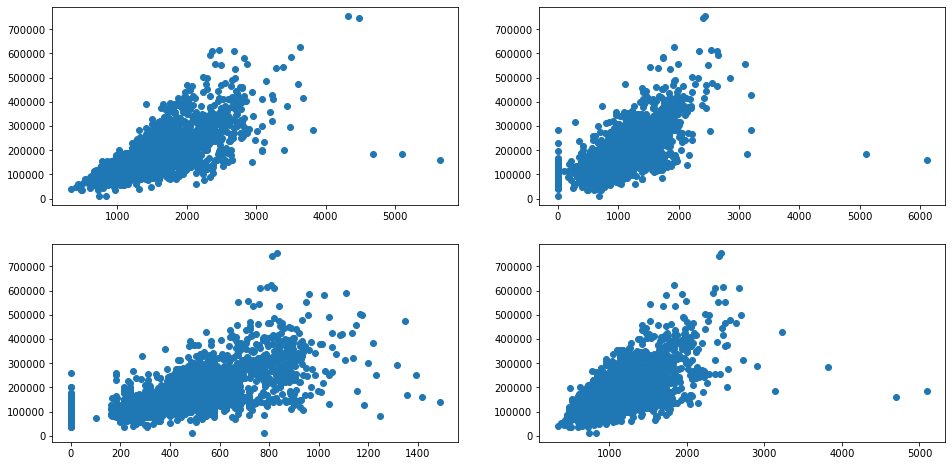

In [17]:
fig, ax = plt.subplots(2,2,figsize=(16,8))
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
ax = plt.subplot(221)
plt.scatter(df["Gr Liv Area"], df["SalePrice"])
ax = plt.subplot(222)
plt.scatter(df["Total Bsmt SF"], df["SalePrice"])
ax = plt.subplot(223)
plt.scatter(df["Garage Area"], df["SalePrice"])
ax = plt.subplot(224)
plt.scatter(df["1st Flr SF"], df["SalePrice"])

plt.show()

[24507.44939949051, 24596.38421994478, 26536.606793303476, 25405.5106490999, 25624.05487414705]
25334.001187197144
2905
14.012474153270993  percent of avg price


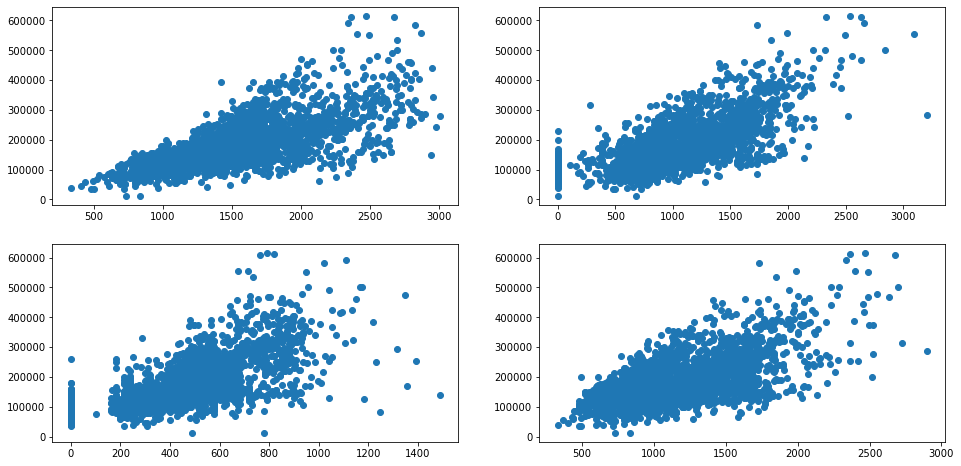

In [21]:
from scipy import stats

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
# df["SalePrice"] = np.log1p(df["SalePrice"])

z = np.abs(stats.zscore(df['Gr Liv Area']))
threshold = 3
np.where(z > 3)
df_test1 = df[(z < 3)]

rmse = pipeline(df=df_test1, t=transform_features3,s=select_features3, r=train_and_test2)
print(rmse)
# fig, ax = plt.subplots(figsize=(16,8))
# plt.scatter(df["Gr Liv Area"], df["SalePrice"])
# plt.show()

fig, ax = plt.subplots(2,2,figsize=(16,8))

ax = plt.subplot(221)
plt.scatter(df_test1["Gr Liv Area"], df_test1["SalePrice"])
ax = plt.subplot(222)
plt.scatter(df_test1["Total Bsmt SF"], df_test1["SalePrice"])
ax = plt.subplot(223)
plt.scatter(df_test1["Garage Area"], df_test1["SalePrice"])
ax = plt.subplot(224)
plt.scatter(df_test1["1st Flr SF"], df_test1["SalePrice"])



print(len(df_test1))
# check the percentage error for INITAL DATASET not the new one
print(rmse/df["SalePrice"].mean() *100, ' percent of avg price')

[23741.90530617172, 25120.01584691503, 21720.031005127705, 25108.780729547387, 24584.63799288953]
24055.074176130274
2855
13.30508760370569  percent of avg price


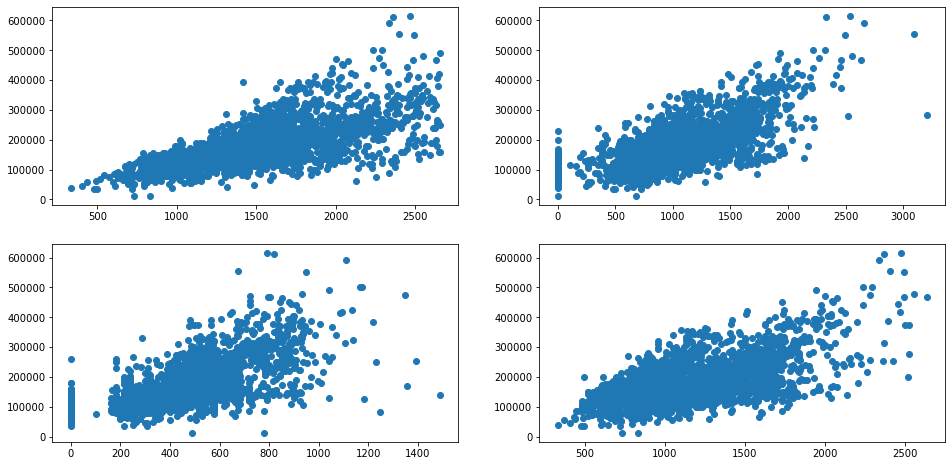

In [23]:

# IQR best so far
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
# df["SalePrice"] = np.log1p(df["SalePrice"])


Q1 = df["Gr Liv Area"].quantile(0.25)
Q3 = df["Gr Liv Area"].quantile(0.75)
IQR = Q3 - Q1
# print(IQR)
# (df["Gr Liv Area"] < (Q1 - 1.5 * IQR)) |(df["Gr Liv Area"] > (Q3 + 1.5 * IQR))
df_test2 = df[~((df["Gr Liv Area"] < (Q1 - 1.5 * IQR)) |(df["Gr Liv Area"] > (Q3 + 1.5 * IQR)))]
# df = test_iqr

rmse = pipeline(df=df_test2,t=transform_features3,s=select_features3, r=train_and_test2)

print(rmse)
# fig, ax = plt.subplots(figsize=(16,8))
# plt.scatter(test_iqr["Gr Liv Area"], test_iqr["SalePrice"])
# plt.show()
print(len(df_test2))
# check the percentage error for INITAL DATASET not the new one
print(rmse/df["SalePrice"].mean() *100, ' percent of avg price')


fig, ax = plt.subplots(2,2,figsize=(16,8))

ax = plt.subplot(221)
plt.scatter(df_test2["Gr Liv Area"], df_test2["SalePrice"])
ax = plt.subplot(222)
plt.scatter(df_test2["Total Bsmt SF"], df_test2["SalePrice"])
ax = plt.subplot(223)
plt.scatter(df_test2["Garage Area"], df_test2["SalePrice"])
ax = plt.subplot(224)
plt.scatter(df_test2["1st Flr SF"], df_test2["SalePrice"])

plt.show()